In [1]:
using Plots
using LinearAlgebra
using FFTW

include("modulation.jl")
include("bits.jl")

decodeGray (generic function with 1 method)

In [2]:
# parameters
Nfft = 64    # number of ofdm subcarriers
Nblocks = 4  # number of ofdm blocks
modOrder = 64
bps = Int(log2(modOrder)) # bits per symbol
numBits = bps * Nfft * Nblocks
modulator = QAM(modOrder)

SNRdB = 60
SNRlin = 10^(SNRdB/10)
N0 = modulator.avgEb/SNRlin

# generate payload data
bitstream = generateBitstream(numBits)
symstream = bitstream2symbolstream(bitstream, bps)
symstreamGray = [ encodeGray(s) for s in symstream ]
symbols = modulate(modulator, symstreamGray)

X = reshape(symbols, (Nfft, Nblocks))

64×4 Array{Complex{Int64},2}:
  3-3im  -7+7im  -1+3im  -5-3im
  5-3im   5-1im   3+7im  -3+7im
 -1-1im  -7+1im  -5+7im  -3+7im
 -5-3im  -1+5im   1+5im  -7-1im
 -5+7im   3+3im  -1+7im  -5-7im
  1-5im   3-3im   1-7im   1+7im
 -7-7im  -3+7im   7-5im   7-5im
 -7+7im  -1-7im   3+7im  -3+7im
  7+5im   1-1im   3-7im  -1-7im
 -1-5im  -1+5im   3-1im   1-1im
  3-3im   1+3im  -3-1im   1-5im
  1-1im  -1+1im   7-7im  -1+7im
 -1-5im   5-7im   1-1im  -7+7im
   ⋮                     
 -7+5im  -7-1im   5-7im  -1+5im
  3+3im   7+5im  -5+1im  -3+1im
 -1+5im   7-1im   1+5im  -5+5im
 -5-7im   5+1im   7+3im   7+5im
  5-5im   3+5im   7-5im   7-1im
  5-7im   5+3im  -3-7im  -1-1im
 -1+1im   3+1im   5+1im  -5+3im
  3+1im  -5-3im   3+7im  -5+3im
 -3+5im  -7+7im  -5+5im  -7-1im
  7+7im  -1+5im  -7+1im   7+7im
 -7+3im   7-3im  -1-1im   7-7im
 -7+1im  -3-7im   3-1im   1+5im

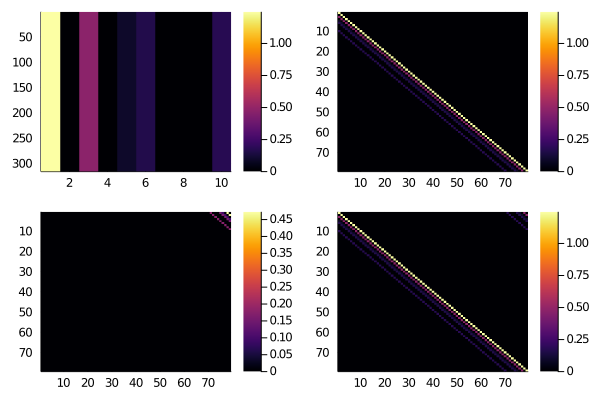

In [3]:
# generate channel taps

function generateRayleighCIR(Nsamples::Int, idxTapDelays::Vector, powTapDelaysDb::Vector, static=true)
    
    Ntaps = maximum(idxTapDelays)
    
    powTapDelaysLin = [ 10^(p/10) for p in powTapDelaysDb ]
    
    Hcir = zeros(Complex, Nsamples, Ntaps)
    for ii = 1:length(idxTapDelays)
        if static
            h = sqrt(powTapDelaysLin[ii]/2) * ( randn(Float64) + im*randn(Float64) )
            Hcir[:,idxTapDelays[ii]] = h*ones(Nsamples,1)
        else
            Hcir[:,idxTapDelays[ii]] = sqrt(powTapDelaysLin[ii]/2) * ( randn(Float64, Nsamples, 1) + im*randn(Float64, Nsamples, 1) )
        end
    end
    
    return Hcir
end

function generateCirculantChannelMatrix(Hcir::Array{Complex,2}, Nblocks::Int, Nsps::Int, Ntaps::Int)
    # convolution
    Hcirc = zeros(Complex, Nblocks, Nsps, Nsps)
    Hisi = zeros(Complex, Nblocks, Nsps, Nsps)

    for kk = 1:Nblocks, nn = 1:Nsps, mm = 1:Nsps
                ii = (kk-1)*Nsps + nn
                jj0 = nn - mm
                jj1 = Nsps + nn - mm

                if jj0 < 0 || jj0 > Ntaps - 1
                    Hcirc[kk, nn, mm] = 0;
                else
                    Hcirc[kk, nn, mm] = Hcir[ii, jj0+1];
                end

                if jj1 < 0 || jj1 > Ntaps - 1
                    Hisi[kk, nn, mm] = 0;
                else
                    Hisi[kk, nn, mm] = Hcir[ii, jj1+1];
                end
    end
    
    return Hcirc, Hisi
end

Ncp = 15  # cyclix prefix length
Nsps = Nfft + Ncp # number of samples per block
Nsamples = Nsps*Nblocks # total number of time samples

idxTapDelays = [1, 3, 5, 6, 10]
powTapDelaysdB = [0, -10, -15, -17, -19] # pdp

Ntaps = maximum(idxTapDelays)# number of channel taps

Hcir = generateRayleighCIR(Nsamples, idxTapDelays, powTapDelaysdB)
Hcirc, Hisi = generateCirculantChannelMatrix(Hcir, Nblocks, Nsps, Ntaps)

p0 = heatmap(abs.(Hcir), yflip=true)
p1 = heatmap(abs.(Hcirc[2,:,:]), yflip=true)
p2 = heatmap(abs.(Hisi[2,:,:]), yflip=true)
p3 = heatmap(abs.(Hcirc[2,:,:]+Hisi[2,:,:]), yflip=true)
plot(p0, p1, p2, p3, layout=4)


In [29]:
# ofdm transmit processing

module OFDMSISO

import LinearAlgebra
import FFTW

function calculateChannelOutput(Xcp::Array, Hcirc::Array{Complex,3}, Hisi::Array{Complex,3}, Nsps::Int, Nblocks::Int, N0::Float64)

    Ycp = zeros(Complex, Nsps, Nblocks)
    for kk = 1:Nblocks

        noi = (sqrt(N0)/sqrt(2)).*(randn(Nsps) + im*randn(Nsps))

        if kk == 1
            Ycp[:,kk] = Hcirc[kk,:,:]*Xcp[:,kk] + noi
        else
            Ycp[:,kk] = Hcirc[kk,:,:]*Xcp[:,kk] + Hisi[kk,:,:]*Xcp[:,kk-1] + noi
        end
    end
    
    return Ycp
    
end

struct Param
    
    Wfft
    Tcp
    Rcp
    Nfft::Int
    Ncp::Int
    Nblocks::Int
    
    function Param(Nfft::Int, Ncp::Int, Nblocks::Int)
        Isc = Matrix{Float64}(LinearAlgebra.I(Nfft));
        Icp = Isc[Nfft-Ncp+1:end,:];
        Wfft = (1/sqrt(Nfft))*FFTW.fft(LinearAlgebra.I(Nfft),1);
        Tcp = vcat(Icp, Isc);                # insert CP
        Rcp = hcat(zeros(Nfft, Ncp), Matrix{Float64}(LinearAlgebra.I(Nfft)) );    # remove CP
        new(Wfft, Tcp, Rcp, Nfft, Ncp, Nblocks) 
    end
    
end


function Modulator(param::Param, X::Array)
    Xcp = param.Tcp*(param.Wfft')*X;
    return Xcp
end

    
function Demodulator(param::Param, Ycp::Array)
    
    # receive ofdm processing

    Y = (param.Wfft)*(param.Rcp)*Ycp;
    return Y
    
end

function FormCSI(param::Param, Hcirc::Array)
   
    Hest = zeros(Complex, param.Nblocks, param.Nfft, param.Nfft)
    for kk = 1:Nblocks
        Hest[kk,:,:] = param.Wfft*param.Rcp*Hcirc[kk,:,:]*param.Tcp*(param.Wfft')
    end
    
    return Hest
    
end

function EqualizerOneTap(Hest::Array, Y::Array)
    
    Xest = zeros(Complex, param.Nfft, param.Nblocks)
    for kk = 1:param.Nblocks
        equalizer = inv(LinearAlgebra.diagm(LinearAlgebra.diag(Hest[kk,:,:])))
        Xest[:,kk] = equalizer*Y[:,kk]
    end  
    
    return Xest
end

end


param = OFDMSISO.Param(Nfft, Ncp, Nblocks)
Xcp = OFDMSISO.Modulator(param, X)
Ycp = calculateChannelOutput(Xcp, Hcirc, Hisi, Nsps, Nblocks, N0)
Y = OFDMSISO.Demodulator(param, Ycp)
Hest = OFDMSISO.FormCSI(param, Hcirc)
Xest = OFDMSISO.EqualizerOneTap(Hest, Y)


symbolsEst = vec(Xest)
symstreamEst = demodulate(modulator, symbolsEst)
symstreamEstGray = [ decodeGray(s) for s in symstreamEst ]
bitstreamEst = symbolstream2bitstream(symstreamEstGray, bps)

bitErrors = sum(bitstream .!= bitstreamEst)

ber = bitErrors/numBits

println(ber)


#effChan = Wfft*Rcp*Hcirc[1,:,:]*Tcp*(Wfft')
#p0 = heatmap(abs.(effChan), yflip=true)

LoadError: UndefVarError: Nblocks not defined

In [5]:
hf = Complex{Float32}.(diag(effChan))
ht = ifft(hf)

p0 = plot(10*log10.(abs.(hf)))
p1 = plot(abs.(ht).^2, line=:stem)
xlims!(0,32)

plot(p0, p1, layout=2)

LoadError: UndefVarError: effChan not defined

In [6]:
struct OFDMParam
    
    Wfft
    Tcp
    Rcp
    
    function OFDMParam(Nfft::Int, Ncp::Int)
        

        Isc = Matrix{Float64}(I(Nfft));
        Icp = Isc[Nfft-Ncp+1:end,:];
        
        Wfft = (1/sqrt(Nfft))*fft(I(Nfft),1);
        Tcp = vcat(Icp, Isc);                # insert CP
        Rcp = hcat(zeros(Nfft, Ncp), Matrix{Float64}(I(Nfft)) );    # remove CP
        new(Wfft, Tcp, Rcp) 
    end
    
end

p = OFDMParam(64, 12)

OFDMParam(Complex{Float64}[0.125 + 0.0im 0.125 + 0.0im … 0.125 + 0.0im 0.125 + 0.0im; 0.125 + 0.0im 0.12439809083402462 - 0.012252142541195075im … 0.1225981600504038 + 0.024386290252016034im 0.12439809083402462 + 0.012252142541195075im; … ; 0.125 + 0.0im 0.1225981600504038 + 0.024386290252016034im … 0.11548494156391084 - 0.04783542904563622im 0.1225981600504038 - 0.024386290252016034im; 0.125 + 0.0im 0.12439809083402462 + 0.012252142541195075im … 0.1225981600504038 - 0.024386290252016034im 0.12439809083402462 - 0.012252142541195075im], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

In [7]:
println(typeof(p))

OFDMParam
